<a href="https://colab.research.google.com/github/modelflows/notebooks/blob/main/deep-learning/modelFlows_ar_pod_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Autoregressive (AR) POD-DL
Official implementation of the autoregressive hybrid POD-DL model.

[R. Abadía-Heredia, A. Corrochano, M. Lopez-Martin, and S. Le Clainche. "Generalization capabilities and robustness of hybrid machine learning models grounded in flow physics compared to purely deep learning models." arXiv:2404.17884 (2024)](https://doi.org/10.48550/arXiv.2404.17884)

**Description**

Autoregressive POD-DL model, which combines proper orthogonal decomposition (POD) with deep learning (DL) models to forecast the dynamics of a high-dimensional flow.

The key hyperameters are the following:

* ```inp_seq``` (int)       -> Number (> 1) of samples that enter as input to the POD-DL model.
* ```out_seq``` (int)       -> Number (>= 1) of predictions computed by the POD-DL model at a time.
* ```batch_size``` (int)    -> Number (> 4) of samples that defines the batch size that is used for training.
* ```train_size``` (float)  -> Percentage ((0,1)) of dataset to use for training the POD-DL model.
* ```num_preds``` (int)     -> Number (>= 1) of steps in the autoregressive process. The total number of predictions will be ```num_preds * out_seq```.
* ```dl_model``` (str)      -> Deep learning forecasting model to use: 'lstm' or 'cnn'. For 'cnn' it must be fulfilled that ```out_seq``` = 6.
* ```decision1``` (str)     -> Type of normalization to perform on the dataset before applying SVD. The available options are: 'no-scaling', 'range', 'standardization' and 'pareto'.
* ```decision2``` (str)     -> Type of normalization to perform on the POD coefficients (VT) after applying SVD on the normalized dataset. The available options are: 'no-scaling', 'range', 'standardization' and 'MaxPerMode'.

To replicate the results in the paper set ```decision1 = 'no-scaling'```, ```decision2 = 'range'``` and ```dl_model = 'lstm'```. For combustion problems it is recommended to play with ```decision1```.

In [ ]:
try:
  import mat73
except:
  !pip install -q mat73
  import mat73

try:
  import hdf5storage
except:
  !pip install hdf5storage

In [ ]:
!pip install -q tensorflow==2.15.0

In [ ]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib.pyplot as plt
import time
import hdf5storage
import scipy.io
from numpy import linalg as LA
import mat73

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Reshape, TimeDistributed, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Convolution1D

In [ ]:
def reverse_scaling(decision, tensor_norm, norm_var_1 = 0.0, norm_var_2 = 0.0):

    if decision == 'no-scaling':

        tensor_not_norm = tensor_norm

    elif decision == 'range' or decision == 'standardization' or decision == 'pareto':

        tensor_not_norm = tensor_norm * norm_var_2 + norm_var_1

    elif decision == 'MaxPerMode':

        tensor_not_norm = tensor_norm * norm_var_1

    return tensor_not_norm

# Hyperparameters

In [ ]:
inp_seq     = 10
out_seq     = 6
batch_size  = 12
train_size  = 0.5
num_preds   = 3 # Total number of predictions = num_preds * out_seq
dl_model    = "lstm"
decision1   = 'no-scaling'
decision2   = 'range'

In [ ]:
if (dl_model == "cnn" and out_seq != 6):

    raise TypeError("When dl_model = 'cnn' then out_seq = 6.")

if (decision1 != "no-scaling" and
    decision1 != "range" and
    decision1 != "standardization" and
    decision1 != "pareto"):

    raise TypeError("'decision1' variable only can take the following values 'no-scaling', 'range', 'standardization' or 'pareto'.")

if (decision2 != "no-scaling" and
    decision2 != "range" and
    decision2 != "standardization" and
    decision2 != "MaxPerMode"):

    raise TypeError("'decision2' variable only can take the following values 'no-scaling', 'range', 'standardization' or 'MaxPerMode'.")

# Load data

In [ ]:
f = mat73.loadmat('./Tensor.mat')
dataset = f['Tensor']
print(dataset.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(3, 100, 40, 64, 599)


# Preprocessing

In [ ]:
if (dataset.ndim == 4):
    dataset = dataset[:,:,:,None,:]

elif (dataset.ndim != 5):
    raise TypeError("The dataset must have dimension 4 or 5.")

## Training/Test split

In [ ]:
dataset_mat = np.copy(dataset)

orig_train_set = np.copy(dataset_mat[..., :int(dataset.shape[-1] * train_size)])

mean_flow = np.mean(orig_train_set, axis = -1, keepdims = True)

orig_train_set -= mean_flow

### Scaling prior SVD

In [ ]:
if decision1 == 'no-scaling':

    norm_var_1_1 = 0.0
    norm_var_1_2 = 0.0
    train_set = orig_train_set

elif decision1 == 'range':

    norm_var_1_1 = np.min(orig_train_set, axis = (1,2,3,4), keepdims = True)
    norm_var_1_2 = np.ptp(orig_train_set, axis = (1,2,3,4), keepdims = True)
    train_set = (orig_train_set - norm_var_1_1) / norm_var_1_2

elif decision1 == 'standardization':

    norm_var_1_1 = np.mean(orig_train_set, axis = (1,2,3,4), keepdims = True)
    norm_var_1_2 = np.std(orig_train_set, axis = (1,2,3,4), keepdims = True)
    train_set = (orig_train_set - norm_var_1_1) / norm_var_1_2

elif decision1 == 'pareto':

    norm_var_1_1 = np.mean(orig_train_set, axis = (1,2,3,4), keepdims = True)
    norm_var_1_2 = np.sqrt(np.std(orig_train_set, axis = (1,2,3,4), keepdims = True))
    train_set = (orig_train_set - norm_var_1_1) / norm_var_1_2

del orig_train_set

In [ ]:
train_set = np.reshape(train_set, [-1, train_set.shape[-1]], order = 'F')
print(train_set.shape)

(768000, 299)


## Singular Value Decomposition

In [ ]:
U, S, VT = np.linalg.svd(train_set, full_matrices = False)

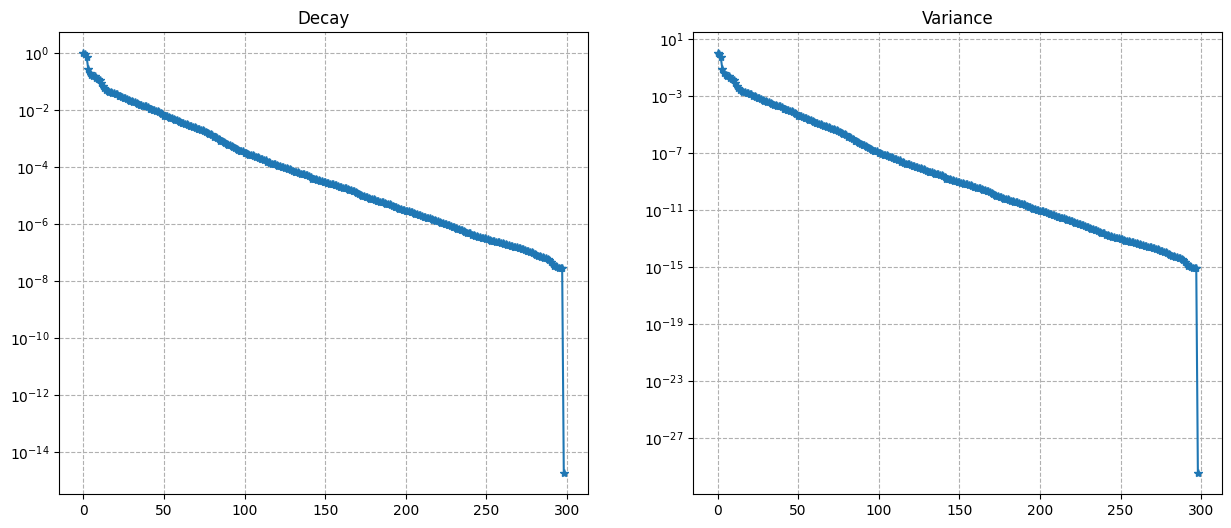

In [ ]:
plt.close('all')

fig, axs = plt.subplots(1, 2, figsize = (15, 6))

axs[0].semilogy(S / S[0], '-*')
axs[0].set_title("Decay")
axs[0].grid(True, linestyle = '--')

_ = S**2 / (len(S) - 1)

axs[1].semilogy(_ / _[0], '-*')
axs[1].set_title("Variance")
axs[1].grid(True, linestyle = '--')

In [ ]:
num_modes = 20

S = np.diag(S[:num_modes])

U = U[:, :num_modes]
VT = VT[:num_modes, :]

## Data scaling

In [ ]:
if decision2 == 'no-scaling':

    norm_var_2_1 = 0.0
    norm_var_2_2 = 0.0
    tensor_norm = VT

elif decision2 == 'range':

    norm_var_2_1 = np.amin(VT)
    norm_var_2_2 = np.ptp(VT)
    tensor_norm = (VT - norm_var_2_1) / norm_var_2_2

elif decision2 == 'standardization':

    norm_var_2_1 = np.mean(VT)
    norm_var_2_2 = np.std(VT)
    tensor_norm = (VT - norm_var_2_1) / norm_var_2_2

elif decision2 == 'MaxPerMode':

    norm_var_2_1 = sum(np.amax(np.abs(VT), axis = 1))
    norm_var_2_2 = 0.0
    tensor_norm = VT / norm_var_2_1

In [ ]:
# Dataset configuration
total_length = tensor_norm.shape[1]
channels_n = 0
dim_x = tensor_norm.shape[0]
dim_y = 0

print('\n-----------------------------')
print('Dataset configuration: \n')
print('total_length: ', total_length)
print('channels_n: ', channels_n)
print('dim_x: ', dim_x)
print('dim_y: ', dim_y)


-----------------------------
Dataset configuration: 

total_length:  299
channels_n:  0
dim_x:  20
dim_y:  0


## Rolling window

In [ ]:
# Data generator
import math
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, list_IDs, batch_size, dim, k, p, shuffle = True,
            till_end = False, only_test = False):
        'Initialization'
        self.data = data
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.p = p
        self.k = k
        self.till_end = till_end
        self.only_test = only_test
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.till_end:
            lenx = math.ceil((len(self.list_IDs) / self.batch_size))
        else:
            lenx = int(np.floor(len(self.list_IDs) / self.batch_size))
        return lenx

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        if self.only_test:
            return X
        else:
            return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, depth)
        # Initialization
        X = np.empty((self.batch_size, self.dim, self.k))
        y = [np.empty((self.batch_size, self.dim))]*self.p

        y_inter = np.empty((self.batch_size, self.dim, self.p))

        # Generate data
        lenn = len(list_IDs_temp)
        for i, ID in enumerate(list_IDs_temp):
            # Store Xtrain
            X[i,:,:] = self.data[:,ID:ID+self.k]
            # Store Ytrain
            y_inter[i,:,:] = self.data[:,ID+self.k:ID+self.k+self.p]

        for j in range(self.p):
            y[j] = y_inter[:,:,j]
            y[j] = np.reshape(y[j], (lenn, -1), order = 'F')

        X = X.transpose((0,2,1))

        return X, y

In [ ]:
stride_train = 1
stride_val = 1
stride_test = 1

dim=(dim_x)

train_length = train_set.shape[-1]

if int(train_length-(inp_seq + out_seq)) < 0:
    train_n = 0
elif int((train_length-(inp_seq + out_seq))//stride_train) == 0:
    train_n = 1
else:
    train_n = int((train_length-(inp_seq + out_seq))//stride_train)

train_idxs = np.empty([train_n], dtype='int')

j = 0
for i in range(train_n):
    train_idxs[i] = j
    j = j+stride_train

# Generators
training_generator = DataGenerator(
    tensor_norm,
    train_idxs,
    dim = dim,
    batch_size = batch_size,
    k = inp_seq,
    p = out_seq,
    till_end = False,
    only_test = False,
    shuffle = True
)

In [ ]:
print('\n-----------------------------')
print('Model training summary: \n')
print ('train_length: ', train_length)
print()
print('Number mini-batches for training: ', len(training_generator))


-----------------------------
Model training summary: 

train_length:  299

Number mini-batches for training:  23


# DL model

In [ ]:
def create_model_lstm(in_shape, out_dim, p, neurons, shared_dim, act_fun, act_func2,
    lr, lf
):

    tf.keras.backend.clear_session()


    x = Input(shape=in_shape)


    v = LSTM(neurons)(x)

    v = Dense(p * neurons, activation = act_fun)(v)

    v = Reshape((p, neurons))(v)
    tt = [1]*p

    r = TimeDistributed( Dense(shared_dim, activation=act_fun))(v)
    s = tf.split(r, tt, 1)
    for i in range(p):
        s[i] = Flatten()(s[i])

    o = []
    for i in range(p):
        o.append( Dense(out_dim, activation=act_func2)(s[i]) )

    m = Model(inputs=x, outputs=o)
    opt = keras.optimizers.Adam(learning_rate=lr)
    m.compile(loss=lf, optimizer=opt, metrics=[lf])

    return(m)

def create_model_cnn(in_shape,  out_dim, p = 3, shared_dim = 1000, act_fun = 'relu'):
    x = Input(shape=in_shape)
    v = Convolution1D(30,3)(x)
    v = Convolution1D(60,3)(v)
    v = Dense(100, activation = act_fun)(v)
    # v = Reshape((p, 100))(v)

    tt = [1]*p

    r = TimeDistributed( Dense(shared_dim, activation = act_fun))(v)

    s = tf.split(r, tt, 1)
    for i in range(p):
        s[i] = Flatten()(s[i])

    o = []
    for i in range(p):
        o.append( Dense(out_dim, activation='sigmoid')(s[i]) )

    m = Model(inputs=x, outputs=o)
    m.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return(m)

In [ ]:
#create the model

in_shape    = [inp_seq, dim_x]
out_dim     = dim_x
shared_dim  = 80

if (dl_model == "lstm"):

    neurons = 200
    lr      = 1e-3
    lf      = 'mse'

    model = create_model_lstm(
        in_shape,
        out_dim,
        out_seq,
        neurons,
        shared_dim,
        'relu',
        'linear',
        lr,
        lf
    )

elif (dl_model == "cnn"):

    model = create_model_cnn(in_shape, out_dim, out_seq, shared_dim)

else:

    raise TypeError("The variable dl_model must be either 'lstm' or 'cnn'.")

print('\nModel Summary:\n')
model.summary()


Model Summary:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 20)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 200)                  176800    ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 1200)                 241200    ['lstm[0][0]']                
                                                                                                  
 reshape (Reshape)           (None, 6, 200)               0         ['dense[0][0]']               
                                                                             

In [ ]:
# save the best weights
save_string = 'saved_models/' + 'hybrid_dl'

# save the best weights
save_best_weights = save_string + '.h5'
save_summary_stats = save_string + '.csv'
save_last_weights = save_string + '_last_w.h5'
save_results_metrics = save_string + '_results_metrics.csv'

# Training

In [ ]:
# Training
np.random.seed(247531338)
t0 = time.time()
# Model training
callbacks = [
    ModelCheckpoint(save_best_weights, monitor='loss', save_best_only=True, mode='auto'),
    # EarlyStopping(monitor='loss', patience = 50, verbose = 1, mode = 'auto', min_delta = 0.0001)
    ]

print('\nTraining Model Please Wait...\n')

history = model.fit(
    training_generator,
    epochs = 300,
    callbacks = callbacks
)

t1 = time.time()
print('\nModel Trained Successfully!')

print(f"\nTraining complete. Time elapsed: {np.round(((t1 - t0) / 60.), 2)} minutes")


Training Model Please Wait...

Epoch 1/300
23/23 [==============================] - 3s 11ms/step - loss: 0.3965 - dense_2_loss: 0.0598 - dense_3_loss: 0.0619 - dense_4_loss: 0.0553 - dense_5_loss: 0.0687 - dense_6_loss: 0.0911 - dense_7_loss: 0.0596 - dense_2_mse: 0.0598 - dense_3_mse: 0.0619 - dense_4_mse: 0.0553 - dense_5_mse: 0.0687 - dense_6_mse: 0.0911 - dense_7_mse: 0.0596
Epoch 2/300
13/23 [===============>..............] - ETA: 0s - loss: 0.0315 - dense_2_loss: 0.0056 - dense_3_loss: 0.0052 - dense_4_loss: 0.0047 - dense_5_loss: 0.0044 - dense_6_loss: 0.0062 - dense_7_loss: 0.0053 - dense_2_mse: 0.0056 - dense_3_mse: 0.0052 - dense_4_mse: 0.0047 - dense_5_mse: 0.0044 - dense_6_mse: 0.0062 - dense_7_mse: 0.0053

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 0s 10ms/step - loss: 0.0307 - dense_2_loss: 0.0053 - dense_3_loss: 0.0051 - dense_4_loss: 0.0048 - dense_5_loss: 0.0047 - dense_6_loss: 0.0058 - dense_7_loss: 0.0052 - dense_2_mse: 0.0053 - dense_3_mse: 0.0051 - dense_4_mse: 0.0048 - dense_5_mse: 0.0047 - dense_6_mse: 0.0058 - dense_7_mse: 0.0052
Epoch 3/300
23/23 [==============================] - 0s 11ms/step - loss: 0.0231 - dense_2_loss: 0.0039 - dense_3_loss: 0.0038 - dense_4_loss: 0.0038 - dense_5_loss: 0.0038 - dense_6_loss: 0.0039 - dense_7_loss: 0.0039 - dense_2_mse: 0.0039 - dense_3_mse: 0.0038 - dense_4_mse: 0.0038 - dense_5_mse: 0.0038 - dense_6_mse: 0.0039 - dense_7_mse: 0.0039
Epoch 4/300
23/23 [==============================] - 0s 9ms/step - loss: 0.0240 - dense_2_loss: 0.0040 - dense_3_loss: 0.0040 - dense_4_loss: 0.0040 - dense_5_loss: 0.0039 - dense_6_loss: 0.0040 - dense_7_loss: 0.0040 - dense_2_mse: 0.0040 - dense_3_mse: 0.0040 - dense_4_mse: 0.0040 - dense_5_mse: 0.0039 - de

# Plot loss function

In [ ]:
summary_stats = pd.DataFrame({
    'epoch': [ i + 1 for i in history.epoch ],
    'train_loss': history.history['loss']
})

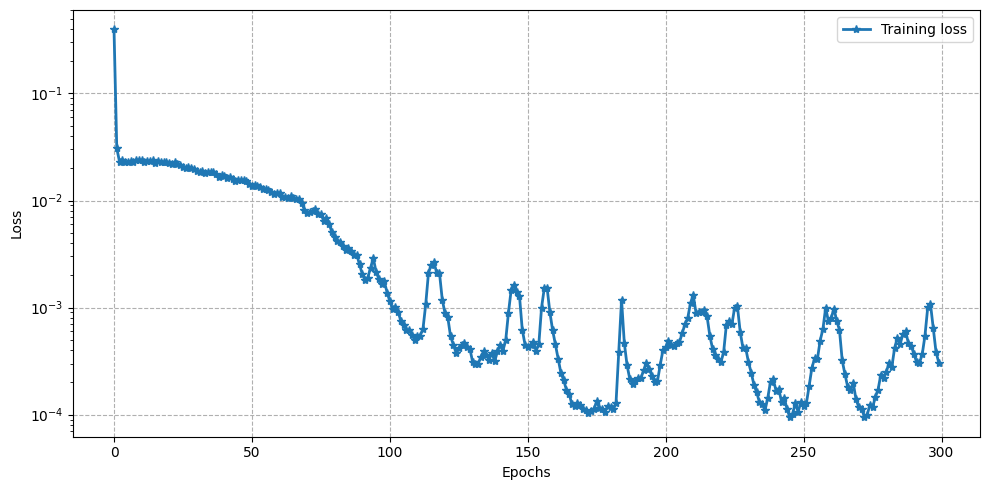

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.semilogy(summary_stats.train_loss, '-*', label = 'Training loss', linewidth = 2)
ax.grid(True, linestyle = '--')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

fig.tight_layout()

figName = "loss_evolution_hybrid_dl.jpg"
plt.savefig(figName, format = 'jpg')
plt.show()

# Forecasting

In [ ]:
def autoregressive_forecasting(model, last_seq, num_preds, out_seq, decision2,
    US, data_shape, mean_flow, save_best_weights):

    model.load_weights(save_best_weights)

    preds = np.zeros([num_modes, num_preds * out_seq])

    in_nn = np.copy(last_seq)

    for i1 in range(num_preds):

        pred = model.predict(in_nn, verbose = 0)
        pred = np.stack(pred, axis = 1)
        preds[:, i1 * out_seq : (i1+1) * out_seq] = np.copy(pred[0, ...].T)

        in_nn = np.concatenate([in_nn[:,out_seq:,:], pred], axis = 1)

    preds = reverse_scaling(decision2, preds, norm_var_2_1, norm_var_2_2)

    preds_ten = US @ preds
    preds_ten = np.reshape(preds_ten, [*data_shape[:-1], num_preds * out_seq], order = 'F')
    preds_ten = reverse_scaling(decision1, preds_ten, norm_var_1_1, norm_var_1_2)
    preds_ten += mean_flow

    return preds_ten

In [ ]:
last_seq = tensor_norm.T[None, -inp_seq:, :]

predictions = autoregressive_forecasting(model, last_seq, num_preds, out_seq, decision2,
    U @ S, dataset.shape, mean_flow, save_best_weights)

Text(0.5, 1.0, 'POD-DL')

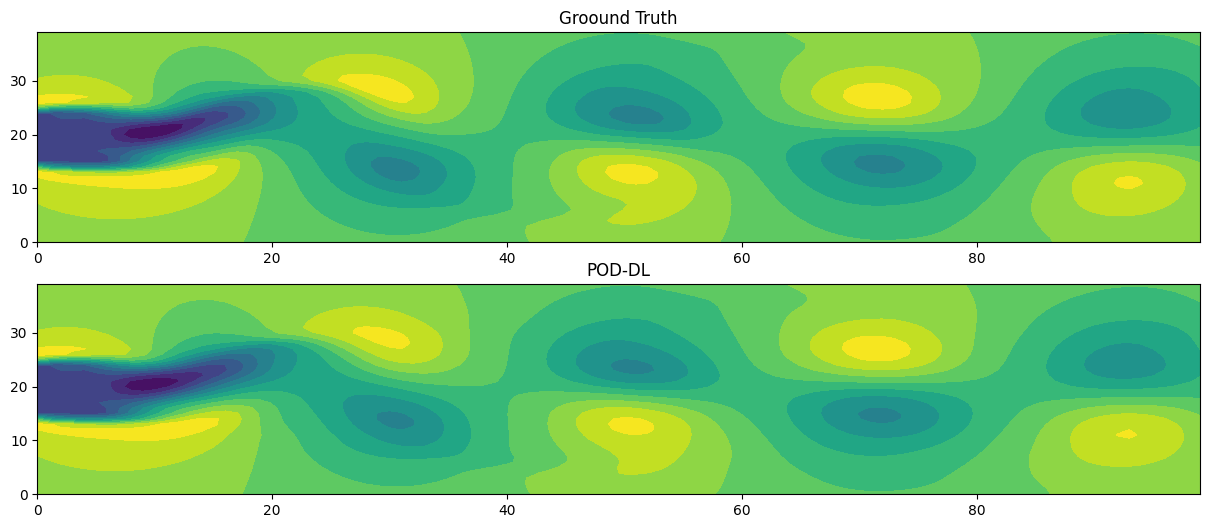

In [ ]:
fig, axs = plt.subplots(2, 1, figsize = (15, 6))

snap = 17
comp = 0

vmin = dataset[comp,:,:,32,tensor_norm.shape[-1] + snap].min()
vmax = dataset[comp,:,:,32,tensor_norm.shape[-1] + snap].max()

axs[0].contourf(dataset[comp,:,:,32,tensor_norm.shape[-1] + snap].T, 12, vmax = vmax, vmin = vmin)
axs[0].set_title('Groound Truth')
axs[1].contourf(predictions[comp,:,:,32,snap].T, 12, vmax = vmax, vmin = vmin)
axs[1].set_title('POD-DL')